The intent of this algorithm is to model the numerous and complex factors used to determine if a health insurance company should cover the costs of a hospital visit or not. Phrased another way: should the health insurance company cover the costs to make that person healthy again and provide the service the person pays for, or should they not cover the costs and leave the person in a lifetime of financial hardships because they happen to become ill? Many health insurance providers struggle to strike the right balance between providing the purported service for their clients and trying to make as much profit as possible from wherever possible. This algorithm models those scenarios and provides a simple, succinct, and mathematically rigorous recommendation to ease this tremendous burden from the claims adjusters.

The availability of data in this domain is severely limited, and rightly so, due to HIPAA laws. Given what’s available, the scenario modeled here are situations where the health insurance provider (in this case the federal government acting through Medicare) has provided coverage for health care costs after an in-patient hospital visit. However, this data is riddled with issues. Through a preliminary analysis, numerous situations where the coverage amounts to less than the full cost of the hospital visit were identified. Because this misaligns with the expected behavior from the heath care provider, these observations are treated as anomalous and are excluded from the training data in order to produce a less biased machine learning model.

The features of the model capture a few attributes from the claimant, the diagnosis given by health care professionals, and the amount of time required to successfully provide care. The target variable is the percent amount of coverage provide by the health insurance company.

#### Training data:
- ["CMS 2008-2010 Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF)" dataset](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html)

In [25]:
%config InlineBackend.figure_format = 'retina'

import glob
import json
import os
import re
import zipfile
import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn_transformers.preprocessing import FeatureSelector
from sklearn_transformers.preprocessing import MultiColumnLabelEncoder
from sklearn_transformers.classification import BinaryClassifierWithNoise
from helpers import classifier_report 

In [2]:
def handle_zip(filename, label):
    with zipfile.ZipFile(filename, 'r') as f:
        f.extractall(f'{label}')
    for fn in glob.glob(f'{label}/*.csv'):
        _filename, _ext = os.path.splitext(os.path.basename(s))
        new_local = f'{os.path.dirname(fn)}__raw_data{_ext}'
        os.replace(fn, new_local)
    os.rmdir(f'{label}/')
    os.remove(filename)
    return new_local

### Download data:

The primary source of data for this model comes from Centers for Medicaid & Medicare Services through a series of datasets named the Data Entrepreneurs’ Synthetic Public Use File or DE-SynPUF for short. From the website:
>The DE-SynPUF was created with the goal of providing a realistic set of claims data in the public domain while providing the very highest degree of protection to the Medicare beneficiaries’ protected health information.

There are two datasets that will be used for this model: the Beneficiary summary data, and the Inpatient Claims data. The Beneficiary summary data contains information about the beneficiary of the claim, and for the purposes of this model only the gender, race, and birthdate will be used. The Inpatient Claims data describes the nature of the claim itself, and will be limited to only information about the price of the services, the financial liabilities placed upon the patient, the primary diagnosis, and the duration of the stay at the hospital.

In [35]:
base_url = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
year_range = range(2008, 2011)
sample_range = range(1, 21)

for year in year_range:
    for sample_number in sample_range:
        url = f'{base_url}DE1_0_{year}_Beneficiary_Summary_File_Sample_{sample_number}.zip'
        filename = os.path.basename(url)
        label = os.path.splitext(filename)[0]
        response = requests.get(url)
        if response.status_code != 200:
            print(f'ERROR: {response.url}, {response.status_code}')
            continue
        with open(filename, 'wb') as out_file:
            out_file.write(response.content)
        new_filename = handle_zip(filename, label)
        print(f'successfully downloaded [{url}] to [{new_filename}]')

successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_1.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_1__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_2.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_2__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_3.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_3__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_4.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_4__raw_data.csv]
successfully downloaded 

successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_15.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_15__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_16.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_16__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_17.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_17__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_18.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_18__raw_data.csv]
successfully dow

In [3]:
beneficiary_filenames = [filename for filename in glob.glob('data/*__raw_data.csv') if 'beneficiary' in filename.lower()]
beneficiary_df = pd.concat([pd.read_csv(f) for f in beneficiary_filenames])
print(beneficiary_df.shape)
beneficiary_df.sample(5)

(6760520, 32)


,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
45119,6353629D3C0EDD69,19370901,NaN,1,1,0,54,150,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36403,501076D1B0208304,19420801,NaN,2,1,0,26,940,12,12,...,2,0.0,0.0,0.0,400.0,590.0,0.0,1140.0,440.0,0.0
34693,4CEAADC4EBA949E7,19430401,NaN,1,1,0,28,590,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58789,85A438B618E42E14,19460401,NaN,1,1,0,34,540,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69771,9A0F00382816EFA2,19110501,NaN,2,1,0,50,70,12,12,...,2,4080.0,1024.0,0.0,410.0,310.0,0.0,7830.0,1280.0,0.0


In [41]:
base_url = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
year_range = range(2008, 2011)
sample_range = range(1, 21)

for sample_number in sample_range:
    url = f'{base_url}DE1_0_2008_to_2010_Inpatient_Claims_Sample_{sample_number}.zip'
    filename = os.path.basename(url)
    label = os.path.splitext(filename)[0]
    response = requests.get(url)
    if response.status_code != 200:
        print(f'ERROR: {response.url}, {response.status_code}')
        continue
    with open(filename, 'wb') as out_file:
        out_file.write(response.content)
    new_filename = handle_zip(filename, label)
    print(f'successfully downloaded [{url}] to [{new_filename}]')

successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_1__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_2.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_2__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_3.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_3__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_4.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_4__raw_data.csv]
successfully downloaded 

In [4]:
claims_filenames = [filename for filename in glob.glob('data/*__raw_data.csv') if 'inpatient_claims' in filename.lower()]
claims_df = pd.concat([pd.read_csv(f) for f in claims_filenames])
print(claims_df.shape)
claims_df.sample(5)

(1332822, 81)


,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
66494,FEE17FD6CF850A2C,939151173163473,1,20090218.0,20090221.0,25T0KQ,4000.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29417,72A7554620880380,790601146283432,1,20090509.0,20090516.0,3601HV,1000.0,0.0,7.373925e+09,7.348893e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13481,3430B1DD942814FD,692081107795104,1,20091115.0,20091117.0,1900RC,5000.0,0.0,5.934131e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20638,4E9F7A6ED7F86C1F,45711150061323,1,20091011.0,20091019.0,23006G,41000.0,0.0,1.499150e+09,3.236463e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40452,9BFEBD9BDF069C64,692251107824631,1,20091220.0,20091225.0,3902XB,6000.0,0.0,9.468399e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocess:

In order to transform the raw data into a state prepared for modeling, some preprocessing must occur. The preprocesing step for this model is fairly complex and relies heavily on the documentation provided by the Centers for Medicaid & Medicare Services. The numerous fields found within the DE-SynPUF data are described at length in the [Centers for Medicare and Medicaid Services (CMS) Linkable 2008–2010 Medicare Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF) User Manual](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf).

In [6]:
beneficiary_df = beneficiary_df[[
    'DESYNPUF_ID',
    'GENDER',
    'RACE',
    'BIRTHDATE',
]]
beneficiary_df = beneficiary_df.rename(columns={
    'BENE_SEX_IDENT_CD': 'GENDER',
    'BENE_RACE_CD': 'RACE',
    'BENE_BIRTH_DT': 'BIRTHDATE',
})

In [7]:
claims_df = claims_df[[
    'DESYNPUF_ID', 
    'ICD9_DGNS_CD_1',
    'PRVDR_NUM',
    'CLM_UTLZTN_DAY_CNT',
    'CLM_THRU_DT',
    'CLM_PMT_AMT',
    'CLM_PASS_THRU_PER_DIEM_AMT',
    'NCH_PRMRY_PYR_CLM_PD_AMT',
    'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
    'NCH_BENE_IP_DDCTBL_AMT',
    'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
]]
claims_df['NCH_PRMRY_PYR_CLM_PD_AMT'] = claims_df['NCH_PRMRY_PYR_CLM_PD_AMT'].fillna(0)
claims_df['NCH_BENE_PTA_COINSRNC_LBLTY_AM'] = claims_df['NCH_BENE_PTA_COINSRNC_LBLTY_AM'].fillna(0)
claims_df['NCH_BENE_IP_DDCTBL_AMT'] = claims_df['NCH_BENE_IP_DDCTBL_AMT'].fillna(0)
claims_df['NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'] = claims_df['NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'].fillna(0)

In [8]:
df = claims_df.merge(beneficiary_df, on='DESYNPUF_ID')
df = df.rename(columns={column: column.strip().lower().replace(' ', '_') for column in df.columns})
df = df.dropna(subset=['icd9_dgns_cd_1'])
df = df.drop_duplicates()
print(df.shape)
df.sample(5)

(1331036, 14)


,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,nch_bene_blood_ddctbl_lblty_am,gender,race,birthdate
3840414,A0BCE563F639E02F,41401,2100RT,1.0,20081212.0,11000.0,0.0,0.0,0.0,1024.0,0.0,2,1,19330101
2052668,779AD53D5468DBB2,74761,2801QQ,7.0,20080612.0,7000.0,0.0,0.0,0.0,1024.0,0.0,1,1,19351001
2300414,E3B2B06F013C1420,1890,10S0MP,0.0,20090325.0,7000.0,30.0,0.0,0.0,1068.0,0.0,2,1,19260601
1422650,23380719339989BC,41071,26026J,2.0,20100427.0,9000.0,70.0,0.0,0.0,1100.0,0.0,2,1,19260301
938333,B50849AC9D0AE5F4,42731,5000KV,2.0,20100218.0,4000.0,40.0,0.0,0.0,1100.0,0.0,2,1,19190901


There are five predominant steps for feature engineering:`determine_duration_bin()`, `decode_icd9()`, `provider_state_name`, `age_range`, `determine_coverage()`, as well as the cleanup and standarization of some columns.

The first step, `determine_duration_bin()`, is a simple truncation of the length in days of the patient’s claim duration into categorical ranges loosely based on the volume of entries that fall into these bins, ensuring similarly size bins are used within the model.

In [9]:
def determine_duration_bin(claim_duration):
    if claim_duration == 1:
        return '1 day'
    elif claim_duration == 2:
        return '2 days'
    elif claim_duration == 3:
        return '3 days'
    elif claim_duration == 4:
        return '4 days'
    elif claim_duration == 5:
        return '5 days'
    elif 5 < claim_duration <= 7:
        return '6-7 days'
    elif 7 < claim_duration <= 14:
        return '8-14 days'
    elif 14 < claim_duration:
        return '15 days or more'
    return

df['claim_duration'] = df['clm_utlztn_day_cnt'].apply(determine_duration_bin).astype('category')
df = df.dropna(subset=['claim_duration'])
df.sample(5)

,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,nch_bene_blood_ddctbl_lblty_am,gender,race,birthdate,claim_duration
2600534,6575C107A91D3387,27651,5000PS,4.0,20080522.0,3000.0,0.0,0.0,0.0,1024.0,0.0,1,1,19210101,4 days
3617533,82D4EC8CC8C9302F,27651,0700JR,10.0,20090429.0,5000.0,0.0,0.0,0.0,1068.0,0.0,2,1,19570601,8-14 days
1158604,CF811592179E3F3D,486,45T1MP,8.0,20090629.0,9000.0,0.0,0.0,0.0,1068.0,0.0,2,1,19401201,8-14 days
2351742,25D64E8F5EA9158F,57410,3720RJ,6.0,20090422.0,16000.0,0.0,0.0,0.0,1068.0,0.0,2,1,19190801,6-7 days
1162314,D43726CA7610D4ED,7802,4100AC,1.0,20100305.0,4000.0,0.0,0.0,0.0,1100.0,0.0,1,1,19660501,1 day


The diagnosis claim codes come in the form of an [ICD-9](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems#ICD-9) code based on the [International Classification of Diseases](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems) maintained by the [World Health Organization (WHO)](https://en.wikipedia.org/wiki/World_Health_Organization). The code ranges used by the function `decode_icd9()` are based on the categorical groupings outlined [here](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). This step is used to condense the wide range of ICD-9 codes into groups of similar codes which reduces the complexity of this field when modeling, while still generally describing the nature of the health care professional’s original diagnosis.

In [10]:
icd9_regex = re.compile(r'^[A-Z]')

def decode_icd9(code):
    if icd9_regex.match(str(code)):
        return 'external causes of injury and supplemental classification'
    code = int(str(code)[:3])
    if 1 <= code <= 139:
        return 'infectious and parasitic diseases'
    elif 140 <= code <= 239: 
        return 'neoplasms'
    elif 240 <= code <= 279: 
        return 'endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= code <= 289: 
        return 'diseases of the blood and blood-forming organs'
    elif 290 <= code <= 319: 
        return 'mental disorders'
    elif 320 <= code <= 389: 
        return 'diseases of the nervous system and sense organs'
    elif 390 <= code <= 459: 
        return 'diseases of the circulatory system'
    elif 460 <= code <= 519: 
        return 'diseases of the respiratory system'
    elif 520 <= code <= 579: 
        return 'diseases of the digestive system'
    elif 580 <= code <= 629: 
        return 'diseases of the genitourinary system'
    elif 630 <= code <= 679: 
        return 'complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= code <= 709: 
        return 'diseases of the skin and subcutaneous tissue'
    elif 710 <= code <= 739: 
        return 'diseases of the musculoskeletal system and connective tissue'
    elif 740 <= code <= 759: 
        return 'congenital anomalies'
    elif 760 <= code <= 779: 
        return 'certain conditions originating in the perinatal period'
    elif 780 <= code <= 799: 
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= code <= 999: 
        return 'injury and poisoning'
    return

df['diagnosis_class'] = df['icd9_dgns_cd_1'].apply(decode_icd9)
df[['diagnosis_class']].sample(5)

,diagnosis_class
2725398,diseases of the circulatory system
1519376,"endocrine, nutritional and metabolic diseases,..."
388343,diseases of the circulatory system
3045430,"symptoms, signs, and ill-defined conditions"
1662175,diseases of the skin and subcutaneous tissue


This step converts the `prvdr_num`, representing the medical facility hosting the individual, into the name of the state where the facility is located. This improves the predictive power of the model by adding geographical nuance to the situations represented in the data.

In [11]:
states_df = pd.DataFrame([
    {'provider_code': '01', 'provider_state_abbr': 'AL', 'provider_state_name': 'alabama'},
    {'provider_code': '02', 'provider_state_abbr': 'AK', 'provider_state_name': 'alaska'},
    {'provider_code': '03', 'provider_state_abbr': 'AZ', 'provider_state_name': 'arizona'},
    {'provider_code': '04', 'provider_state_abbr': 'AR', 'provider_state_name': 'arkansas'},
    {'provider_code': '05', 'provider_state_abbr': 'CA', 'provider_state_name': 'california'},
    {'provider_code': '06', 'provider_state_abbr': 'CO', 'provider_state_name': 'colorado'},
    {'provider_code': '07', 'provider_state_abbr': 'CT', 'provider_state_name': 'connecticut'},
    {'provider_code': '08', 'provider_state_abbr': 'DE', 'provider_state_name': 'delaware'},
    {'provider_code': '09', 'provider_state_abbr': 'DC', 'provider_state_name': 'washington dc'},
    {'provider_code': '10', 'provider_state_abbr': 'FL', 'provider_state_name': 'florida'},
    {'provider_code': '11', 'provider_state_abbr': 'GA', 'provider_state_name': 'georgia'},
    {'provider_code': '12', 'provider_state_abbr': 'HI', 'provider_state_name': 'hawaii'},
    {'provider_code': '13', 'provider_state_abbr': 'ID', 'provider_state_name': 'idaho'},
    {'provider_code': '14', 'provider_state_abbr': 'IL', 'provider_state_name': 'illinois'},
    {'provider_code': '15', 'provider_state_abbr': 'IN', 'provider_state_name': 'indiana'},
    {'provider_code': '16', 'provider_state_abbr': 'IA', 'provider_state_name': 'iowa'},
    {'provider_code': '17', 'provider_state_abbr': 'KS', 'provider_state_name': 'kansas'},
    {'provider_code': '18', 'provider_state_abbr': 'KY', 'provider_state_name': 'kentucky'},
    {'provider_code': '19', 'provider_state_abbr': 'LA', 'provider_state_name': 'louisiana'},
    {'provider_code': '20', 'provider_state_abbr': 'ME', 'provider_state_name': 'maine'},
    {'provider_code': '21', 'provider_state_abbr': 'MD', 'provider_state_name': 'maryland'},
    {'provider_code': '22', 'provider_state_abbr': 'MA', 'provider_state_name': 'massachusetts'},
    {'provider_code': '23', 'provider_state_abbr': 'MI', 'provider_state_name': 'michigan'},
    {'provider_code': '24', 'provider_state_abbr': 'MN', 'provider_state_name': 'minnesota'},
    {'provider_code': '25', 'provider_state_abbr': 'MS', 'provider_state_name': 'mississippi'},
    {'provider_code': '26', 'provider_state_abbr': 'MO', 'provider_state_name': 'missouri'},
    {'provider_code': '27', 'provider_state_abbr': 'MT', 'provider_state_name': 'montana'},
    {'provider_code': '28', 'provider_state_abbr': 'NE', 'provider_state_name': 'nebraska'},
    {'provider_code': '29', 'provider_state_abbr': 'NV', 'provider_state_name': 'nevada'},
    {'provider_code': '30', 'provider_state_abbr': 'NH', 'provider_state_name': 'new hampshire'},
    {'provider_code': '31', 'provider_state_abbr': 'NJ', 'provider_state_name': 'new jersey'},
    {'provider_code': '32', 'provider_state_abbr': 'NM', 'provider_state_name': 'new mexico'},
    {'provider_code': '33', 'provider_state_abbr': 'NY', 'provider_state_name': 'new york'},
    {'provider_code': '34', 'provider_state_abbr': 'NC', 'provider_state_name': 'north carolina'},
    {'provider_code': '35', 'provider_state_abbr': 'ND', 'provider_state_name': 'north dakota'},
    {'provider_code': '36', 'provider_state_abbr': 'OH', 'provider_state_name': 'ohio'},
    {'provider_code': '37', 'provider_state_abbr': 'OK', 'provider_state_name': 'oklahoma'},
    {'provider_code': '38', 'provider_state_abbr': 'OR', 'provider_state_name': 'oregon'},
    {'provider_code': '39', 'provider_state_abbr': 'PA', 'provider_state_name': 'pennsylvania'},
    {'provider_code': '41', 'provider_state_abbr': 'RI', 'provider_state_name': 'rhode island'},
    {'provider_code': '42', 'provider_state_abbr': 'SC', 'provider_state_name': 'south carolina'},
    {'provider_code': '43', 'provider_state_abbr': 'SD', 'provider_state_name': 'south dakota'},
    {'provider_code': '44', 'provider_state_abbr': 'TN', 'provider_state_name': 'tennessee'},
    {'provider_code': '45', 'provider_state_abbr': 'TX', 'provider_state_name': 'texas'},
    {'provider_code': '46', 'provider_state_abbr': 'UT', 'provider_state_name': 'utah'},
    {'provider_code': '47', 'provider_state_abbr': 'VT', 'provider_state_name': 'vermont'},
    {'provider_code': '49', 'provider_state_abbr': 'VA', 'provider_state_name': 'virginia'},
    {'provider_code': '50', 'provider_state_abbr': 'WA', 'provider_state_name': 'washington'},
    {'provider_code': '51', 'provider_state_abbr': 'WV', 'provider_state_name': 'west virginia'},
    {'provider_code': '52', 'provider_state_abbr': 'WI', 'provider_state_name': 'wisconsin'},
    {'provider_code': '53', 'provider_state_abbr': 'WY', 'provider_state_name': 'wyoming'},
    {'provider_code': '40', 'provider_state_abbr': 'PR', 'provider_state_name': 'puerto rico'},
])

df['provider_code'] = df['prvdr_num'].str[:2]
df = df.merge(states_df, left_on='provider_code', right_on='provider_code')
df = df.rename(columns={'provider_state_name': 'facility_state'})
df[['prvdr_num', 'provider_code', 'facility_state']].sample(5)

,prvdr_num,provider_code,facility_state
541064,0505HT,05,california
653119,2200QQ,22,massachusetts
192294,1501ZA,15,indiana
1042852,45T2GQ,45,texas
651689,2200QQ,22,massachusetts


This step is to creates the `age_range` feature by using the beneficiary's birthdate to calculate the age they were when they were hospitalized, then that age is truncated to a decade span.

In [12]:
df['clm_thru_dt'] = pd.to_datetime(df['clm_thru_dt'], format='%Y%m%d')
df['birthdate'] = pd.to_datetime(df['birthdate'], format='%Y%m%d')
df['age'] = df['clm_thru_dt'].dt.year - df['birthdate'].dt.year
df['age_min'] = np.floor(df['age'] / 10) * 10
df['age_max'] = np.ceil((df['age'] + 1) / 10) * 10
df['age_range'] = df['age_min'].astype('int64').map(str) + '-' + df['age_max'].astype('int64').map(str)
df[['birthdate', 'clm_thru_dt', 'age', 'age_min', 'age_max', 'age_range']].sample(5)

,birthdate,clm_thru_dt,age,age_min,age_max,age_range
1281492,1936-11-01,2008-07-31,72,70.0,80.0,70-80
43150,1967-10-01,2008-08-01,41,40.0,50.0,40-50
28512,1979-05-01,2009-05-07,30,30.0,40.0,30-40
1263311,1972-04-01,2009-08-27,37,30.0,40.0,30-40
1171288,1936-03-01,2008-10-16,72,70.0,80.0,70-80


As mentioned above, only the observations in the data where the beneficiary paid exactly \\$0.00 for their deductible and where the insurance provider also paid more than \\$0.00 are included in the training data. These situations represent the expectations of the beneficiary when they sign up for their health insurance provider: the person pays a monthly fee to the provider, and in turn the provide covers the costs of health care if the person unfortunately requires medical attention. Since there are numerous cases where a person had to pay costs beyond what they're already paying to the insurance provider in the form of a deductible, these observations are excluded from the model and treated as anomalous.

In [15]:
df = df[(df['nch_bene_ip_ddctbl_amt'] == 0) & (df['clm_pmt_amt'] >= 0)]

The following step is to calculate the percent amount of coverage the insuance provider paid of the total bill. The first calculation determines how much the benficiary paid (`amount_paid_by_beneficiary`), and is a sum of the columns where some financial burden offloaded onto the hospitalized person. The next calculation, `amount_covered_by_insurers`, determines the amount paid by the insurers. These two numbers combined equals the  `total_amount` of the claim. From there the `percent_covered_by_insurers` is derived. Lastly, the `percent_covered_by_insurers` is converted into a binary class representing cases when the insurance provider covered 100\% of the costs, and when they failed to do so. This is the `coverage` field that will be used as the target variable in the model.

The fields below are [defined](https://www.resdac.org/cms-data/files/op-ffs/data-documentation) as:
- `nch_bene_pta_coinsrnc_lblty_am` : The amount of money for which the intermediary has determined that the beneficiary is liable for Part A coinsurance on the institutional claim.
- `nch_bene_ip_ddctbl_amt`: The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the institutional claim.
- `nch_bene_blood_ddctbl_lblty_am`: The amount of money for which the intermediary determined the beneficiary is liable for the blood deductible. A blood deductible amount applies to the first 3 pints of blood (or equivalent units; applies only to whole blood or packed red cells - not platelets, fibrinogen, plasma, etc. which are considered biologicals).
- `clm_pmt_amt`: The Medicare claim payment amount.
- `clm_pass_thru_per_diem_amt`: Medicare establishes a daily payment amount to reimburse IPPS hospitals for certain “pass-through” expenses, such as capital-related costs, direct medical education costs, kidney acquisition costs for hospitals that are renal transplant centers, and bad debts. This variable is the daily payment rate for pass-through expenses. It is not included in the CLM_PMT_AMT field. To determine the total of the pass-through payments for a hospitalization, this field should be multiplied by the claim Medicare utilization day count (CLM_UTLZTN_DAY_CNT). Then, total Medicare payments for a hospitalization claim can be determined by summing this product and the CLM_PMT_AMT field. 
- `clm_utlztn_day_cnt`: On an institutional claim, the number of covered days of care that are chargeable to Medicare facility utilization that includes full days, coinsurance days, and lifetime reserve days.
- `nch_prmry_pyr_clm_pd_amt`: The amount of a payment made on behalf of a Medicare beneficiary by a primary payer other than Medicare, that the provider is applying to covered Medicare charges on a non-institutional claim. 

In [16]:
def determine_coverage(values):
    return np.where(values == 1, '100', '0')

df['amount_paid_by_beneficiary'] = df['nch_bene_pta_coinsrnc_lblty_am'] + df['nch_bene_ip_ddctbl_amt'] + df['nch_bene_blood_ddctbl_lblty_am']
df['amount_covered_by_insurers'] = df['clm_pmt_amt'] + (df['clm_pass_thru_per_diem_amt'] * df['clm_utlztn_day_cnt']) + df['nch_prmry_pyr_clm_pd_amt']
df['total_amount'] = df['amount_covered_by_insurers'] + df['amount_paid_by_beneficiary']
df['percent_covered_by_insurers'] = df['amount_covered_by_insurers'] / df['total_amount']
df = df.dropna(subset=['percent_covered_by_insurers'])
df['coverage'] = determine_coverage(df['percent_covered_by_insurers'])
df['coverage'] = df['coverage'].astype(str)
df.sample(5)

,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,...,facility_state,age,age_min,age_max,age_range,amount_paid_by_beneficiary,amount_covered_by_insurers,total_amount,percent_covered_by_insurers,coverage
921278,1C43F528B3D7B5E4,5967,2100NQ,19.0,2008-03-25,7000.0,0.0,0.0,0.0,0.0,...,maryland,84,80.0,90.0,80-90,0.0,7000.0,7000.0,1.0,100
149104,AD7529FE5D3D0E40,8082,4200CT,5.0,2010-02-02,5000.0,200.0,0.0,0.0,0.0,...,south carolina,50,50.0,60.0,50-60,0.0,6000.0,6000.0,1.0,100
26322,BAD73B99F939328C,72888,4901NS,12.0,2008-04-25,7000.0,0.0,0.0,0.0,0.0,...,virginia,79,70.0,80.0,70-80,0.0,7000.0,7000.0,1.0,100
291780,4A2F06069E49F0F7,51883,3301QB,14.0,2009-04-06,57000.0,0.0,0.0,0.0,0.0,...,new york,79,70.0,80.0,70-80,0.0,57000.0,57000.0,1.0,100
214950,1986F9186B2A113C,03811,3600CS,43.0,2009-07-02,31000.0,0.0,0.0,0.0,0.0,...,ohio,86,80.0,90.0,80-90,0.0,31000.0,31000.0,1.0,100


Lastly, a few field replacements are used to transform numeric codes into human-readable categorical values.

In [17]:
field_replacements = {
    'race': {
        1: 'white',
        2: 'black',
        3: 'others',
        5: 'hispanic',
    },
    'gender': {
        1: 'male',
        2: 'female',
    }
}

df['race'] = df['race'].apply(lambda x: field_replacements['race'].get(x)).astype('category')
df['gender'] = df['gender'].apply(lambda x: field_replacements['gender'].get(x)).astype('category')
df[['race', 'gender']].sample(5)

,race,gender
926372,white,male
452588,hispanic,male
245000,white,male
563470,white,female
555193,white,female


### Model:

In [21]:
df.to_csv('insurance_data.csv', index=False)

# df = pd.read_csv('insurance_data.csv')

In [19]:
feature_columns = ['gender', 'race', 'age_range', 'claim_duration', 'diagnosis_class', 'facility_state']
target_column = 'coverage'

data_df = pd.concat([df, df, df]) # This step simulates more observations to help improve the model’s performance.

x = data_df.copy()[feature_columns]
y = data_df.copy()[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

print(len(x_train), len(x_test))

96813 24204


In [22]:
model = Pipeline([
#     ('feature_selector', FeatureSelector(feature_columns)),
    ('feature_column_encoder', MultiColumnLabelEncoder(columns=feature_columns)),
#     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=True)),
    ('classifier', BinaryClassifierWithNoise(
        RandomForestClassifier(
            n_estimators=100,
            n_jobs=1,
            random_state=1337,
        )
    )),
])
model.fit(x_train, y_train)

Pipeline(steps=[('feature_column_encoder', <sklearn_transformers.preprocessing.MultiColumnLabelEncoder object at 0x7ff284e4a0b8>), ('classifier', BinaryClassifierWithNoise(classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', m...ators=100, n_jobs=1, oob_score=False, random_state=1337,
            verbose=0, warm_start=False)))])

Accuracy:  0.974426
Recall:    0.448193
F-beta:    0.545855
Precision: 0.697936

----------------------------------------
Feature Importances:
race=white                                                                            0.456040
race=others                                                                           0.200693
race=black                                                                            0.176308
race=hispanic                                                                         0.099107
gender=male                                                                           0.035945
gender=female                                                                         0.031907


None

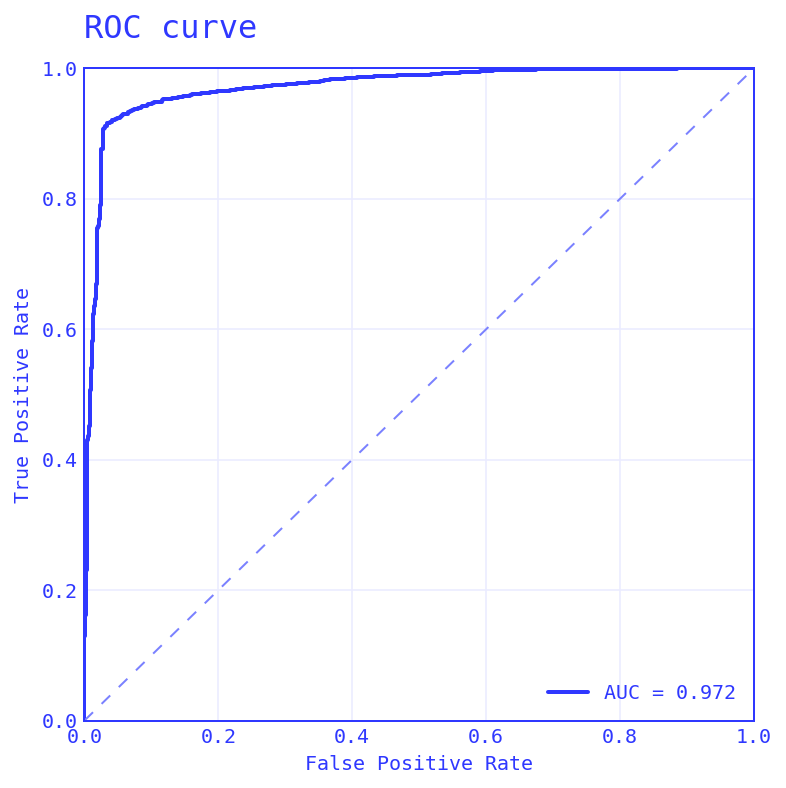

None

[{'0': 0.099148707974412553, '100': 0.90085129202558745},
 {'0': 0.089342208486704974, '100': 0.91065779151329507},
 {'0': 0.023679887610140119, '100': 0.97632011238985983},
 {'0': 0.17942303955558495, '100': 0.82057696044441508},
 {'0': 0.129738936491087, '100': 0.87026106350891297}]

In [26]:
display(classifier_report.performance(model, x_test, y_test, encoder_step_label='feature_column_encoder', cross_validate=False))
display(classifier_report.roc_curve(model, x_test, y_test))
display(model.predict_proba(x_test.sample(5)))

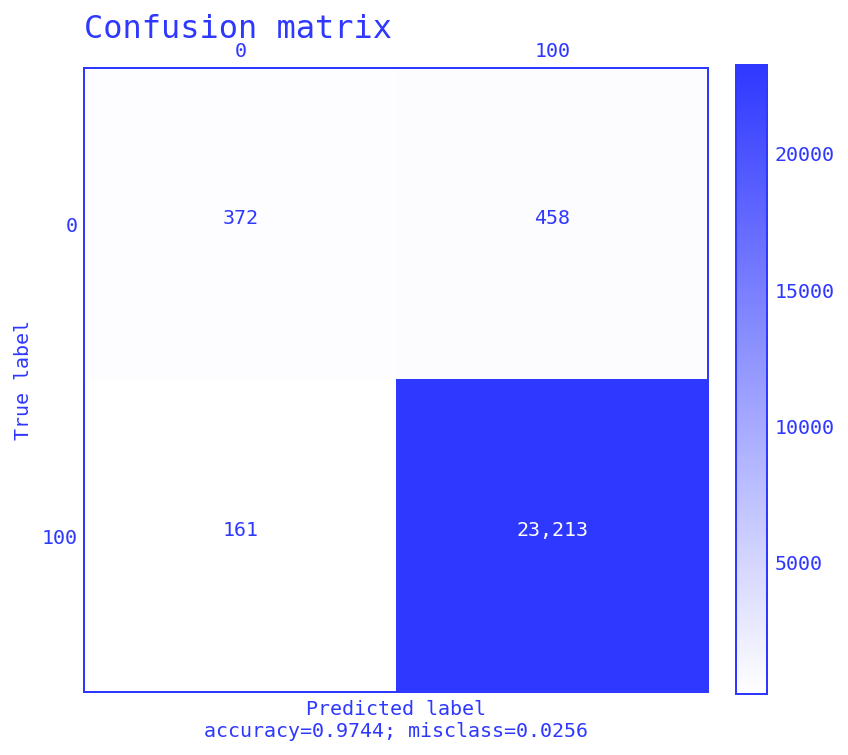

In [30]:
y_pred = model.predict(x_test)
class_names = model.named_steps['classifier'].classifier.classes_
classifier_report.plot_confusion_matrix(y_test, y_pred, class_names=class_names, normalize=False)